# Stateinterpreter (characterizing DeepTICA states)

Reference paper: _Novelli, Bonati, Pontil and Parrinello, [JCTC]((https://pubs.acs.org/doi/abs/10.1021/acs.jctc.2c00393)) (2023)_ 

Prerequisite: LASSO tutorial.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/luigibonati/mlcolvar/blob/main/docs/notebooks/examples/ex_stateinterpreter.ipynb)

## Setup

In [1]:
# Colab setup
import os

if os.getenv("COLAB_RELEASE_TAG"):
    import subprocess
    subprocess.run('wget https://raw.githubusercontent.com/luigibonati/mlcolvar/main/colab_setup.sh', shell=True)
    cmd = subprocess.run('bash colab_setup.sh EXAMPLE', shell=True, stdout=subprocess.PIPE)
    print(cmd.stdout.decode('utf-8'))

# IMPORT PACKAGES
import torch
import lightning
import numpy as np
import matplotlib.pyplot as plt
import mlcolvar.utils.plot

# Set seed for reproducibility
torch.manual_seed(1)

/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This is a short tutorial to interpret the states starting from the sign structure of the eigenfunctions of TICA, as done in this [paper](https://pubs.acs.org/doi/abs/10.1021/acs.jctc.2c00393).

### Load DeepTICA data

We will use the DeepTICA CVs trained for the alanine dipeptide, contained in the [md-stateinterpreter](https://github.com/luigibonati/md-stateinterpreter/) repository.

In [2]:
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.data import DictModule

filenames = [ "https://github.com/luigibonati/md-stateinterpreter/raw/main/tutorials/alanine/COLVAR_DeepTICA" ]
# load dataset
dataset, df = create_dataset_from_files(filenames,
                                        filter_args={'regex':'d_' }, # select distances 
                                        return_dataframe=True, 
                                        index_col=0)

df

Class 0 dataframe shape:  (50001, 56)

 - Loaded dataframe (50001, 56): ['time', 'phi', 'psi', 'theta', 'xi', 'ene', 'd_2_5', 'd_2_6', 'd_2_7', 'd_2_9', 'd_2_11', 'd_2_15', 'd_2_16', 'd_2_17', 'd_2_19', 'd_5_6', 'd_5_7', 'd_5_9', 'd_5_11', 'd_5_15', 'd_5_16', 'd_5_17', 'd_5_19', 'd_6_7', 'd_6_9', 'd_6_11', 'd_6_15', 'd_6_16', 'd_6_17', 'd_6_19', 'd_7_9', 'd_7_11', 'd_7_15', 'd_7_16', 'd_7_17', 'd_7_19', 'd_9_11', 'd_9_15', 'd_9_16', 'd_9_17', 'd_9_19', 'd_11_15', 'd_11_16', 'd_11_17', 'd_11_19', 'd_15_16', 'd_15_17', 'd_15_19', 'd_16_17', 'd_16_19', 'd_17_19', 'ecv.ene', 'opes.bias', 'DeepTICA 1', 'DeepTICA 2', 'walker']
 - Descriptors (50001, 45): ['d_2_5', 'd_2_6', 'd_2_7', 'd_2_9', 'd_2_11', 'd_2_15', 'd_2_16', 'd_2_17', 'd_2_19', 'd_5_6', 'd_5_7', 'd_5_9', 'd_5_11', 'd_5_15', 'd_5_16', 'd_5_17', 'd_5_19', 'd_6_7', 'd_6_9', 'd_6_11', 'd_6_15', 'd_6_16', 'd_6_17', 'd_6_19', 'd_7_9', 'd_7_11', 'd_7_15', 'd_7_16', 'd_7_17', 'd_7_19', 'd_9_11', 'd_9_15', 'd_9_16', 'd_9_17', 'd_9_19', 'd

,time,phi,psi,theta,xi,ene,d_2_5,d_2_6,d_2_7,d_2_9,...,d_15_17,d_15_19,d_16_17,d_16_19,d_17_19,ecv.ene,opes.bias,DeepTICA 1,DeepTICA 2,walker
0,0.0,-2.36867,2.64432,-0.202258,0.048056,-41.45820,0.152064,0.233505,0.241173,0.379827,...,0.130073,0.244001,0.227324,0.281913,0.148169,-41.45820,0.000000,0.884022,0.697792,0
1,1.0,-1.81603,2.26247,0.155789,-0.162735,-34.46170,0.154673,0.238446,0.246100,0.392822,...,0.130751,0.248974,0.224416,0.287066,0.149815,-34.46170,0.000000,0.904663,0.441770,0
2,2.0,-1.96164,2.52240,-0.071315,0.419557,-22.81000,0.153296,0.248231,0.245643,0.384574,...,0.133494,0.240812,0.219853,0.267548,0.146985,-22.81000,0.000000,0.901740,0.715535,0
3,3.0,-1.55273,2.61161,-0.073188,-0.322301,-19.42730,0.146842,0.233290,0.238608,0.375124,...,0.133732,0.243859,0.218035,0.273935,0.141663,-19.42730,0.000000,0.889557,0.327383,0
4,4.0,-1.43251,1.05203,0.210149,-0.033460,-31.27380,0.150544,0.238910,0.240522,0.374435,...,0.135397,0.254622,0.223741,0.285824,0.149050,-31.27380,0.000000,0.895487,-0.841115,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49996,49996.0,-2.71024,3.09736,-0.278662,-0.145443,-17.50420,0.150316,0.237027,0.236800,0.371655,...,0.133984,0.245352,0.224751,0.283270,0.138847,-17.50420,1.543530,0.870904,0.345046,0
49997,49997.0,-2.73993,-3.07790,-0.066902,-0.030009,-9.98505,0.160066,0.240604,0.251294,0.387740,...,0.131298,0.245222,0.229207,0.287379,0.149105,-9.98505,0.983428,0.880671,0.498947,0
49998,49998.0,-1.79181,2.41757,0.454768,0.175903,28.20660,0.144505,0.220241,0.251352,0.389548,...,0.136430,0.243374,0.227492,0.275568,0.144445,28.20660,-14.739900,0.936590,0.497335,0
49999,49999.0,-2.25492,2.65134,-0.023274,0.166437,-31.68510,0.146304,0.232403,0.241591,0.381665,...,0.133528,0.245209,0.224884,0.281453,0.144545,-31.68510,1.717750,0.890656,0.782703,0


## Lasso classifier (2 states)

If we look at the distribution of DeepTICA 1 we see that it identifies two states, which we can label accordingly:

Text(0, 0.5, 'Distribution')

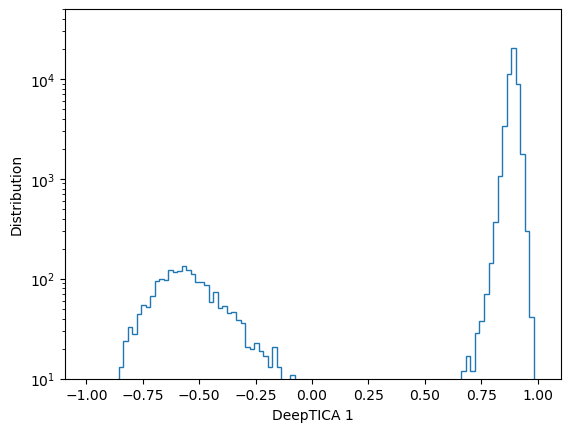

In [3]:
fig, ax = plt.subplots()
ax.hist(df['DeepTICA 1'].values,bins=100,histtype='step')
ax.set_yscale('log')
ax.set_ylim(1e1,5e4)
ax.set_xlabel('DeepTICA 1')
ax.set_ylabel('Distribution')

Create labels

<AxesSubplot:xlabel='time', ylabel='DeepTICA 1'>

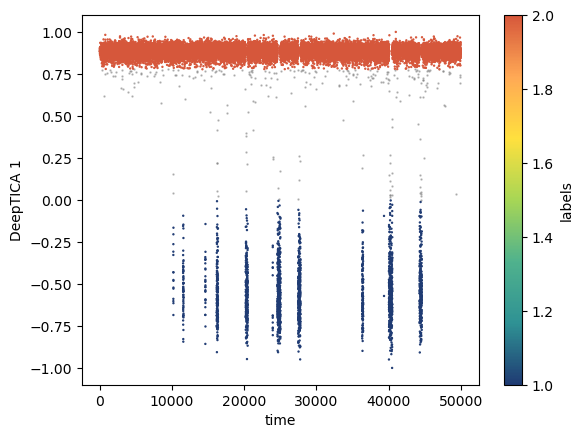

In [5]:
labels = np.zeros(len(df))
labels[np.argwhere(df['DeepTICA 1'].values > 0.78)] = 2
labels[np.argwhere(df['DeepTICA 1'].values < -0.)] = 1
df['labels'] = labels

fig,ax = plt.subplots()
df[df['labels']==0].plot.scatter('time','DeepTICA 1',c='grey', s=0.5,alpha=0.5,ax=ax)
df[df['labels']!=0].plot.scatter('time','DeepTICA 1',c='labels', s=0.5,cmap='fessa',ax=ax)

Create dataset with angles or distances

In [6]:
from mlcolvar.data import DictDataset

sel = (df['labels'] != 0 ) 

descr_type = 'angles' #'distances' 

if descr_type == 'angles': 
    # get descriptors
    X = df[sel].filter(regex='phi|psi|xi|theta').values[::10]
    feat_names = df[sel].filter(regex='phi|psi|xi|theta').columns.values

    # convert to sine and cosine
    X = np.hstack((np.sin(X),np.cos(X)))
    feat_names = [f'sin_{i}' for i in feat_names]+[f'cos_{i}' for i in feat_names]

    # get labels 
    y = df[sel]['labels'].values[::10]

elif descr_type == 'distances':
    # get descriptors
    X = df[sel].filter(regex='d_').values[::10]
    feat_names = df[sel].filter(regex='d_').columns.values

    # get labels 
    y = df[sel]['labels'].values[::10]

# create dataset
dataset = DictDataset(dict(data=X,labels=y))
dataset.feature_names = feat_names 
dataset

DictDataset( "data": [4976, 8], "labels": [4976] )

Perform classification

======= LASSO results (2) ========
- Regularization : 0.00599484
- Score          : -13.58
- Accuracy       : 89.42%
- # features     : 3

Features: 
(1) sin_phi      : -1.556827
(2) cos_phi      : -0.656852
(3) sin_psi      : 0.040250



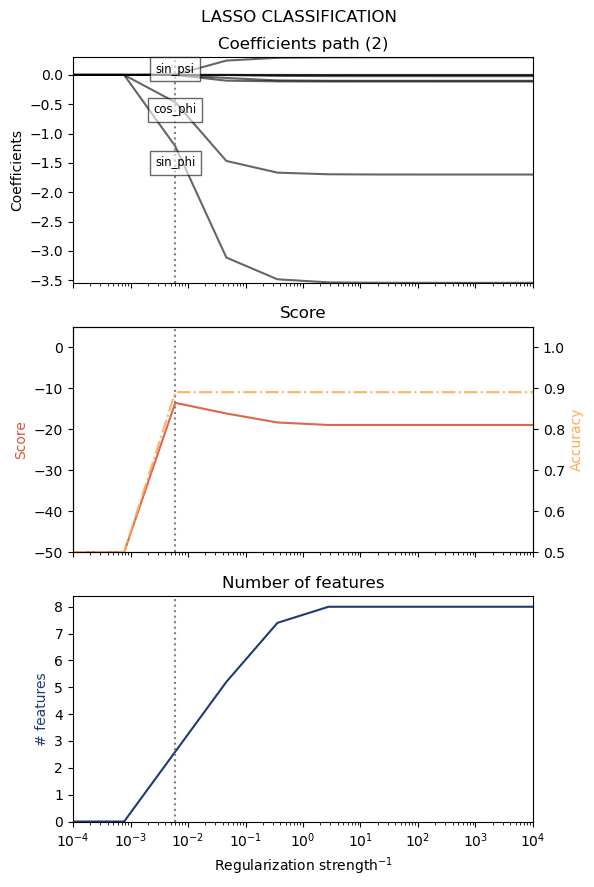

In [7]:
from mlcolvar.explain.lasso import lasso_classification

classifier, feats, coeffs = lasso_classification(dataset, Cs=10, plot=True)

### Lasso classifier (3 states, one vs rest)

If we look instead at both DeepTICA 1 and DeepTICA 2 variables, we see that they identify three distinct states. We can then interpret them using a classifier for each state ('one vs rest') which returns the features that distinguish that state from all the others.

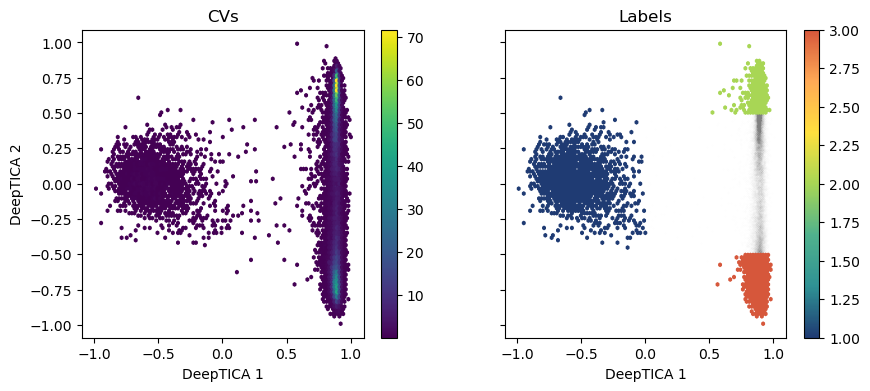

In [9]:
fig,axs = plt.subplots(1,2,figsize=(10,4),sharex=True,sharey=True)

ax = axs[0]
pp = ax.hexbin(df['DeepTICA 1'],df['DeepTICA 2'], C = np.ones(len(df)), reduce_C_function = lambda x: np.sum(x)/10 )
plt.colorbar(pp,ax=ax)

ax = axs[1]

labels = np.zeros(len(df))
labels[np.argwhere( (df['DeepTICA 1'].values < 0) )] = 1 
labels[np.argwhere( (df['DeepTICA 1'].values > 0.5) & (df['DeepTICA 2'].values > 0.5) )] = 2
labels[np.argwhere( (df['DeepTICA 1'].values > 0.5) & (df['DeepTICA 2'].values < -0.5) )] = 3
df['labels'] = labels

df[df['labels']==0].plot.scatter('DeepTICA 1','DeepTICA 2',c='grey', s=0.1,alpha=0.01,ax=ax)
df[df['labels'] != 0].plot.hexbin('DeepTICA 1','DeepTICA 2',C='labels', cmap='fessa',ax=ax)

titles = ['CVs','Labels']
for i,ax in enumerate(axs):
    ax.set_xlabel('DeepTICA 1')
    ax.set_ylabel('DeepTICA 2')
    ax.set_title(titles[i])

Create new dataset

In [10]:
from mlcolvar.data import DictDataset

sel = (df['labels'] != 0 ) 

descr_type = 'angles'#'distances' #

if descr_type == 'angles': 
    # get descriptors
    X = df[sel].filter(regex='phi|psi|xi|theta').values[::10]
    feat_names = df[sel].filter(regex='phi|psi|xi|theta').columns.values

    # convert to sine and cosine
    X = np.hstack((np.sin(X),np.cos(X)))
    feat_names = [f'sin_{i}' for i in feat_names]+[f'cos_{i}' for i in feat_names]

    # get labels 
    y = df[sel]['labels'].values[::10]

elif descr_type == 'distances':
    # get descriptors
    X = df[sel].filter(regex='d_').values[::10]
    feat_names = df[sel].filter(regex='d_').columns.values

    # get labels 
    y = df[sel]['labels'].values[::10]

# create dataset
dataset = DictDataset(dict(data=X,labels=y))
dataset.feature_names = feat_names 
dataset

DictDataset( "data": [3331, 8], "labels": [3331] )

Perform classification

In [11]:
classifier, feats, coeffs = lasso_classification(dataset, plot = False)

======= LASSO results (1) ========
- Regularization : 0.01804722
- Score          : -9.23
- Accuracy       : 93.77%
- # features     : 3

Features: 
(1) sin_phi      : 3.842064
(2) cos_phi      : 2.095998
(3) sin_psi      : -0.727435

======= LASSO results (2) ========
- Regularization : 0.00106082
- Score          : -1.54
- Accuracy       : 99.46%
- # features     : 1

Features: 
(1) cos_psi      : -0.836221

======= LASSO results (3) ========
- Regularization : 0.01125336
- Score          : -3.35
- Accuracy       : 99.65%
- # features     : 3

Features: 
(1) cos_psi      : 2.700127
(2) sin_phi      : -1.191376
(3) sin_psi      : 0.681767



Plot

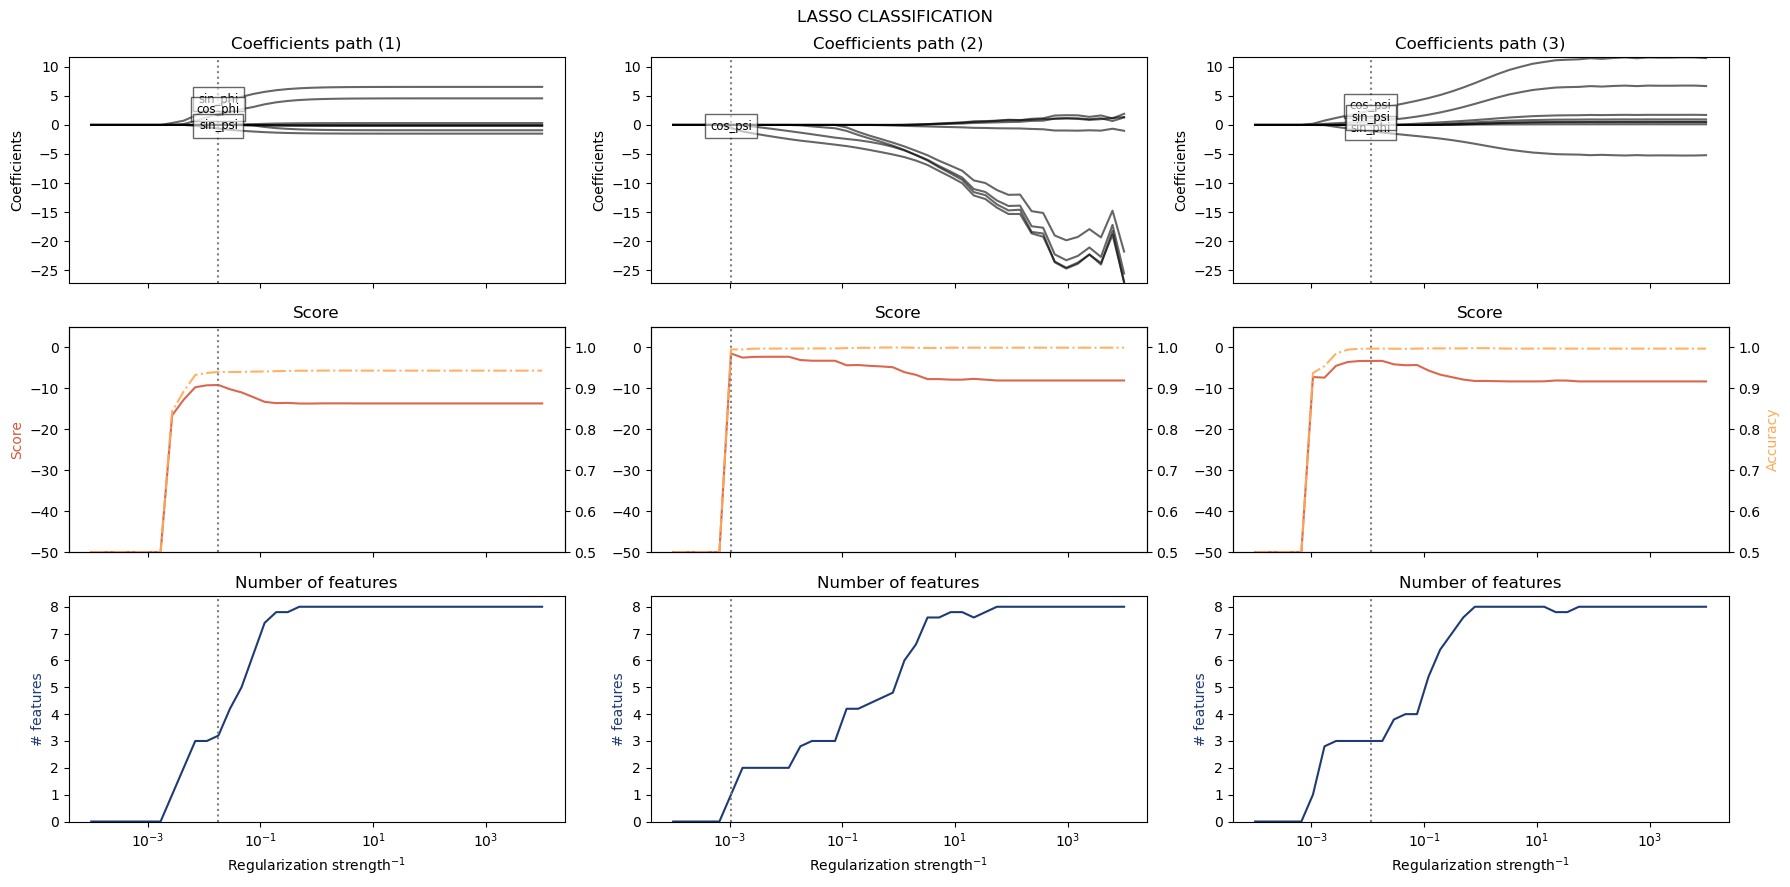

In [12]:
from mlcolvar.explain.lasso import plot_lasso_classification

plot_lasso_classification(classifier,feats,coeffs)